# Signal Processing : Assignment
Pierre Osselin

pierre.osselin@eng.ox.ac.uk

### Import Libraries & Define Functions

In [226]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
import imageio
from skimage import io
from skimage.transform import resize
from scipy.optimize import minimize

In [194]:
def build_M(p, n):
    """Randomly corrupt p% of the signal
    Args:
        p (float in [0,1]): Proportion of the signal corrupted
        n (int) : Signal Size
    Returns:
        M (nxn Array): Matrix of corruption
    """
    
    # Select indices switched off
    indices = np.random.choice(np.arange(n), replace=False, size=int(n * p))

    # Build M
    M = np.zeros((n, n))
    diagonal = np.ones(M.shape[0])
    diagonal[indices] = 0
    row,col = np.diag_indices(M.shape[0])
    M[row,col] = diagonal
    
    return M

## **1.** Problem Optimisation

We want to solve the following (convex) optimisation problem:
\begin{equation}
    \min\limits_{\boldsymbol{x} \in \mathbb{R}^{N}} ||\boldsymbol{y} - \boldsymbol{Mx}||_{2}^{2} + \alpha \ \boldsymbol{x^{T}Lx}
\end{equation}
Where:
\begin{equation*}
\boldsymbol{M}_{i,j} = \left\{
    \begin{array}{ll}
        1 & \mbox{if } i = j \mbox{ and } \boldsymbol{y}(i) \mbox{ is observed},\\
        0 & \mbox{otherwise}
    \end{array}
\right.
\end{equation*}

We differentiate the objective function we try to minimize ($\boldsymbol{M}$ and $\boldsymbol{L}$ are symmetric, $\boldsymbol{M}^2 = \boldsymbol{M}$ and $\boldsymbol{My} = \boldsymbol{y}$):

\begin{equation*}
\nabla_{\boldsymbol{x}} (||\boldsymbol{y} - \boldsymbol{Mx}||_{2}^{2} + \alpha \ \boldsymbol{x^{T}Lx}) = -2\boldsymbol{M}(\boldsymbol{y} - \boldsymbol{x}) + 2\alpha \boldsymbol{Lx} 
\end{equation*}

Setting the gradient to zero gives:
\begin{equation*}
\boxed{\boldsymbol{x} = (\boldsymbol{M} + \alpha \boldsymbol{L})^{-1} \boldsymbol{y}}
\end{equation*}

This Equation can be rewritten as follows in canonical notation:
\begin{equation*}
\boxed{\boldsymbol{x} = \boldsymbol{\chi} ( \boldsymbol{\chi^{T}} \boldsymbol{M} \boldsymbol{\chi} + \alpha \boldsymbol{\Delta})^{-1} \boldsymbol{\chi^{T}} \boldsymbol{y}}
\end{equation*}

In the previous formula, $\boldsymbol{\chi^{T}} \boldsymbol{M} \boldsymbol{\chi}$ cannot be simplified in the general case such that its value is independant of $\boldsymbol{\chi}$ hence $( \boldsymbol{\chi^{T}} \boldsymbol{M} \boldsymbol{\chi} + \alpha \boldsymbol{\Delta})^{-1}$ cannot be interpreted as a filter as its action on the spectrum of a given signal depends on the graph structure.



## **2.** Sensor Graph
### Graph Construction

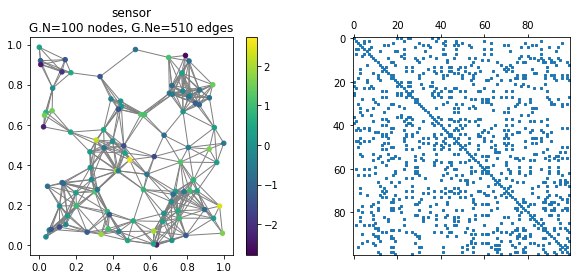

In [195]:
G = graphs.Sensor(N=100)
f = np.random.normal(size=G.N)
G.compute_laplacian('combinatorial')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(f, vertex_size=20, ax=axes[0])
axes[1].spy(G.L, markersize=2)

### Construct Smooth Signal

In [196]:
G.compute_fourier_basis()
n_eigenvector = 15
f = np.sum(G.U[:, 1:n_eigenvector], axis = 1)

In [197]:
mi, ma = np.min(f), np.max(f)
f = (f - mi) / (ma - mi)

C:\Users\Pierre Osselin\miniconda3\envs\cdt_lab_env\lib\site-packages\pygsp\plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


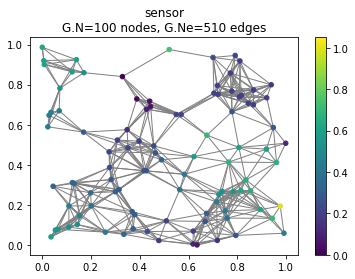

In [198]:
G.plot_signal(f, vertex_size=20)

### Construct Observation

In [199]:
p = 0.5

M = build_M(p, f.size)

# Compute the corrupted image
y = M.dot(f)

Text(0.5, 1.0, 'Partially Observed Signal')

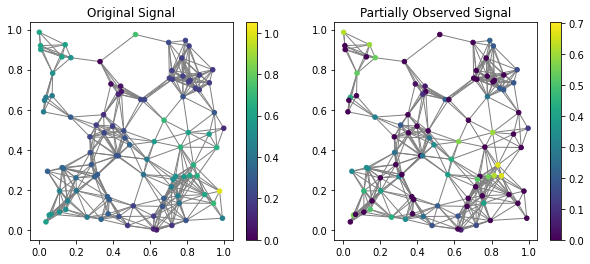

In [200]:
# Plot the original and corrupted image
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(f, vertex_size=20, ax=axes[0])
G.plot_signal(y, vertex_size=20, ax=axes[1])
axes[0].set_title("Original Signal")
axes[1].set_title("Partially Observed Signal")

### Signal Recovery

In [201]:
# Compute the recovered signal
alpha = 1.
f_recovered = np.linalg.solve(M + alpha * G.L, y)

Text(0.5, 1.0, 'Recovered Signal')

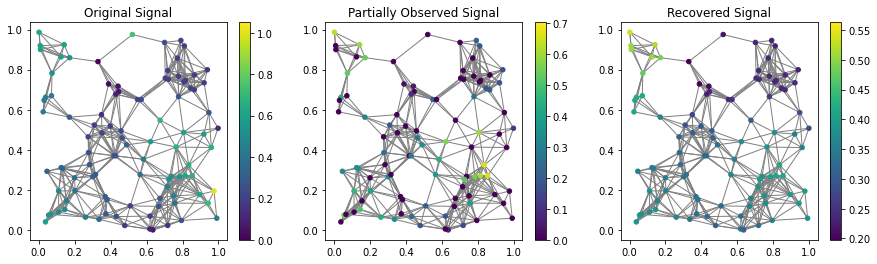

In [202]:
# Plot the result
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
G.plot_signal(f, vertex_size=20, ax=axes[0])
G.plot_signal(y, vertex_size=20, ax=axes[1])
G.plot_signal(f_recovered, vertex_size=20, ax=axes[2])

axes[0].set_title("Original Signal")
axes[1].set_title("Partially Observed Signal")
axes[2].set_title("Recovered Signal")

**Comment** : The distribution of the variation of the signal matches the one of the original image, however the scale of the recovered signal is tighter since we imposed a smoothness constraint over the whole signal

### Influence of p and $\alpha$

Text(0.5, 1.0, 'Partially Observed Signal')

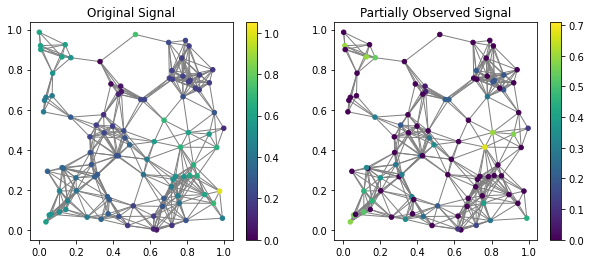

In [204]:
# Influence of alpha

p = 0.6
list_alpha = [0.01, 0.1, 1., 10]

#Build M
M = build_M(p, f.size)

# Compute the corrupted image
y = M.dot(f)

# Plot the original and corrupted image
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(f, vertex_size=20, ax=axes[0])
G.plot_signal(y, vertex_size=20, ax=axes[1])
axes[0].set_title("Original Signal")
axes[1].set_title("Partially Observed Signal")

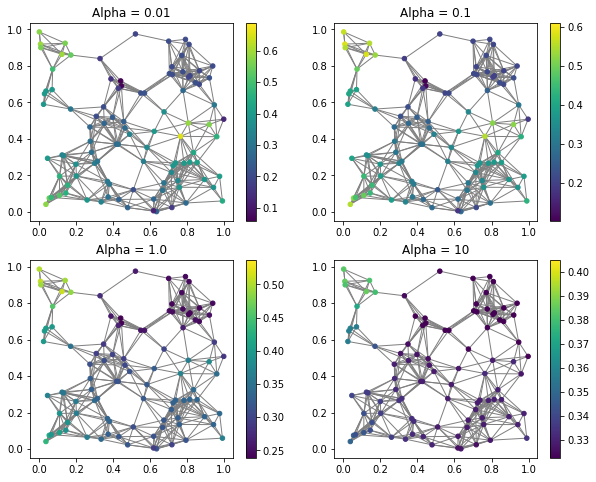

In [208]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
list_error = []

for j, alpha in enumerate(list_alpha):
    # Recover the signal
    f_recovered = np.linalg.solve(M + alpha * G.L, y)
    G.plot_signal(f_recovered, vertex_size=20, ax=axes[j//2, j%2])
    axes[j//2, j%2].set_title("Alpha = {}".format(alpha))

    #Store Error
    list_error.append(np.sum((f - f_recovered)**2))


Text(0.5, 1.0, 'Error btw recovered and original image in function of alpha')

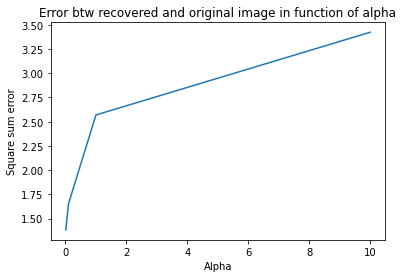

In [213]:
plt.plot(list_alpha, list_error)
plt.xlabel("Alpha")
plt.ylabel("Square sum error")
plt.title("Error btw recovered and original image in function of alpha")

**Comment** : $\alpha$ control the smoothness constraint, for high $\alpha$, the whole signal will be almost uniform, for low $\alpha$, the observed points of the recovered signal will be almost the same as the original signal, and the non-observed points will be near its neighbours ($\alpha$ is not null).

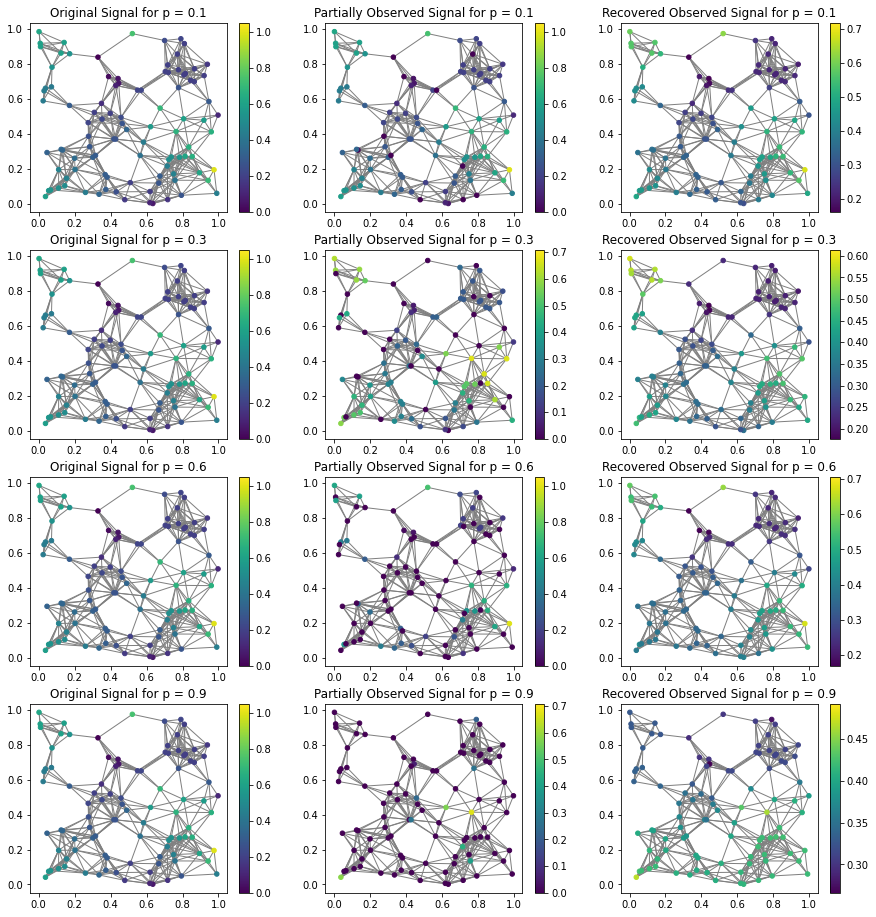

In [217]:
# Influence of p

alpha = 0.5
list_p = [0.1, 0.3, 0.6, 0.9]
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
for i, p in enumerate(list_p):
    
    #Build M
    M = build_M(p, f.size)

    # Compute the corrupted image
    y = M.dot(f)
    f_recovered = np.linalg.solve(M + alpha * G.L, y)

    # Plot the original and corrupted image
    G.plot_signal(f, vertex_size=20, ax=axes[i, 0])
    G.plot_signal(y, vertex_size=20, ax=axes[i, 1])
    G.plot_signal(f_recovered, vertex_size=20, ax=axes[i, 2])
    axes[i, 0].set_title("Original Signal for p = {}".format(p))
    axes[i, 1].set_title("Partially Observed Signal for p = {}".format(p))
    axes[i, 2].set_title("Recovered Observed Signal for p = {}".format(p))

**Comment** : As p grows, the information available shrinks and the recovery become harder. However the smoothness assumption of our signal allows us to leverage the laplacian regularization and recover the signal even when information lacks, in our parcticular example at $p = 0.6$ the recovery is accurate.

## **3.** Cameraman Image

### Loading Image

In [218]:
im = imageio.imread('data/cameraman.tif')

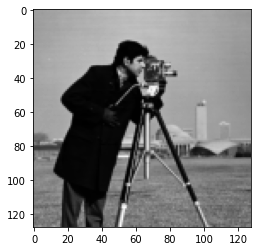

In [219]:
resolution = 128
image = resize(im, (resolution, resolution))
plt.imshow(image, cmap='gray')
plt.show()

### Building Graph

In [220]:
G = graphs.Grid2d(image.shape[0])
f = np.random.normal(size=G.N)
G.compute_laplacian('combinatorial')

C:\Users\Pierre Osselin\miniconda3\envs\cdt_lab_env\lib\site-packages\pygsp\plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


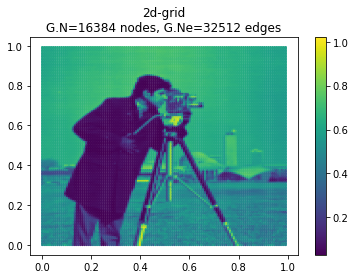

In [221]:
f = image.flatten()
G.plot_signal(f, vertex_size=2)

### Corrupt Image

In [222]:
p = 0.5
indices = np.random.choice(np.arange(f.size), replace=False, size=int(f.size * p))

# Build M
M = build_M(p, f.size)

y = M.dot(f)

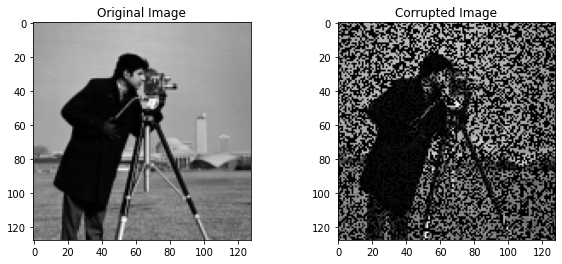

In [223]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image, cmap='gray')
axes[1].imshow(y.reshape((resolution, resolution)), cmap='gray')

axes[0].set_title("Original Image")
axes[1].set_title("Corrupted Image")
plt.show()

### Image Recovery

In [224]:
alpha = 1.
f_recovered = np.linalg.solve(M + alpha * G.L, y)

Text(0.5, 1.0, 'Recovered Signal')

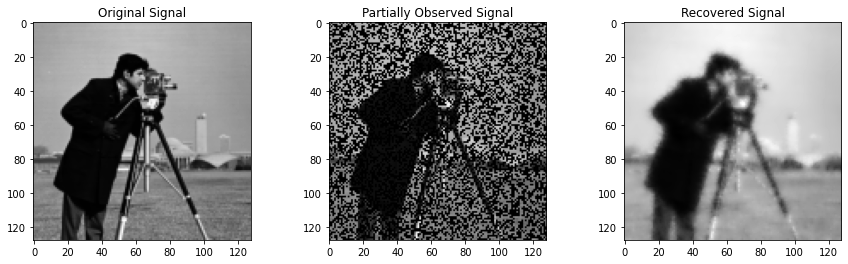

In [225]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(image, cmap='gray')
axes[1].imshow(y.reshape((resolution, resolution)), cmap='gray')
axes[2].imshow(f_recovered.reshape((resolution, resolution)), cmap='gray')


axes[0].set_title("Original Signal")
axes[1].set_title("Partially Observed Signal")
axes[2].set_title("Recovered Signal")

In [239]:
alpha = 0.001
f_recovered = np.linalg.solve(M + alpha * G.L, y)

Text(0.5, 1.0, 'Recovered Signal')

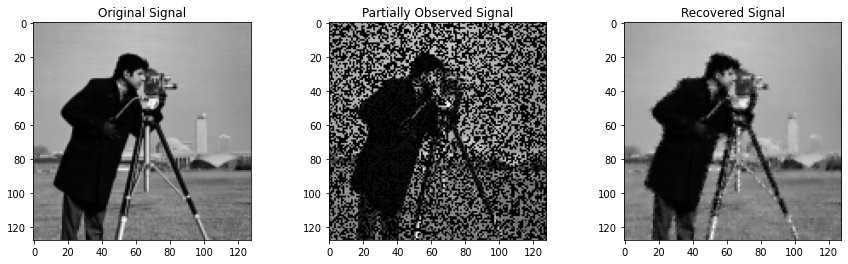

In [240]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(image, cmap='gray')
axes[1].imshow(y.reshape((resolution, resolution)), cmap='gray')
axes[2].imshow(f_recovered.reshape((resolution, resolution)), cmap='gray')


axes[0].set_title("Original Signal")
axes[1].set_title("Partially Observed Signal")
axes[2].set_title("Recovered Signal")

In [233]:
## Best alpha
def objective(alpha):
    f_recovered = np.linalg.solve(M + alpha * G.L, y)
    return np.sum((f_recovered - f)**2)

In [237]:
result = [objective(el) for el in [0.001, 0.01, 0.1, 1.]]

In [238]:
result

[28.039765437782542, 28.39297830711147, 33.118489907027666, 75.20678026777273]

**Comment** : The error decreases, we notice that the resulting image with low $\alpha$ is less blur but the error pixels (in the contour of the cameraman is sharper as well).

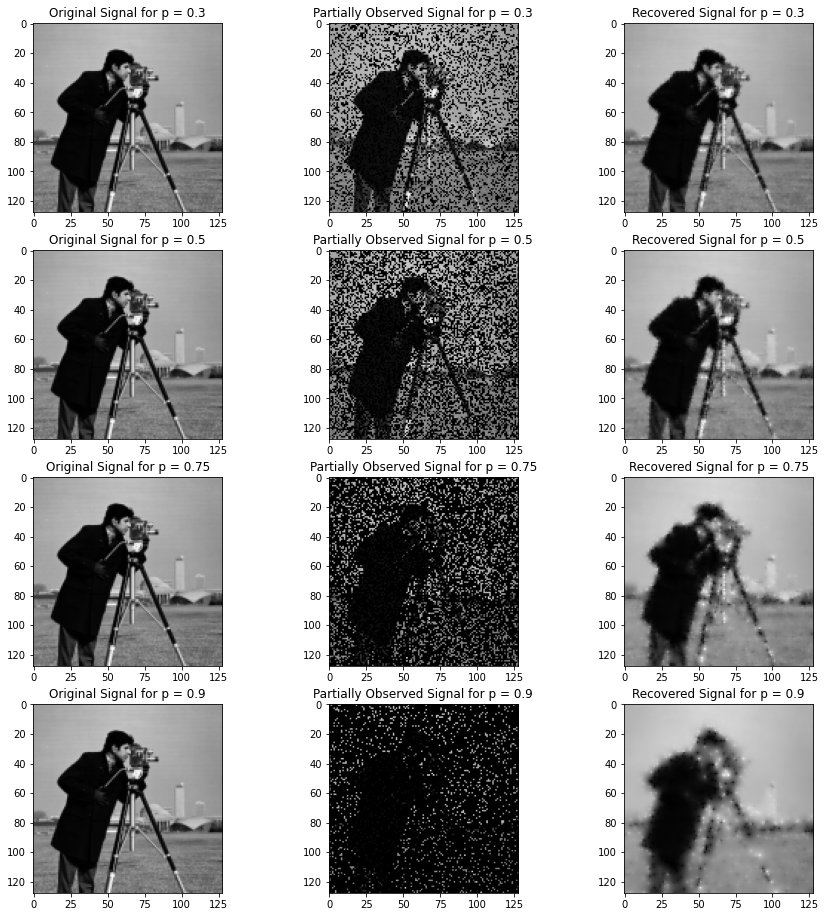

In [241]:
# Influence of p

alpha = 0.1
list_p = [0.3, 0.5, 0.75, 0.9]
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
for i, p in enumerate(list_p):
    
    #Build M
    M = build_M(p, f.size)

    # Compute the corrupted image
    y = M.dot(f)
    
    f_recovered = np.linalg.solve(M + alpha * G.L, y)

    # Plot the original and corrupted image
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 1].imshow(y.reshape((resolution, resolution)), cmap='gray')
    axes[i, 2].imshow(f_recovered.reshape((resolution, resolution)), cmap='gray')


    axes[i, 0].set_title("Original Signal for p = {}".format(p))
    axes[i, 1].set_title("Partially Observed Signal for p = {}".format(p))
    axes[i, 2].set_title("Recovered Signal for p = {}".format(p))

**Comment** : Even at $p = 0.9$ we are able to recognize the elements of the image even if there are blurred.